In [1]:
import gzip
import os
import sys
import urllib
import matplotlib.image as mpimg
from PIL import Image
from helper_deep import *

import code

import tensorflow.python.platform

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

%matplotlib inline
%load_ext autoreload
%autoreload 2

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
NB_IMAGES_TO_LOAD = 100
NB_LABELS = 2
NB_CHANNELS = 3
PATCH_SIZE = 16
BATCH_SIZE = 100
SEED = 0
DEPTH = 32
TRAINING_SET_SIZE = 0.8

In [3]:
# Load a set of images
root_dir = "Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
imgs = [load_image(image_dir + files[i]) for i in range(NB_IMAGES_TO_LOAD)]

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(NB_IMAGES_TO_LOAD)]

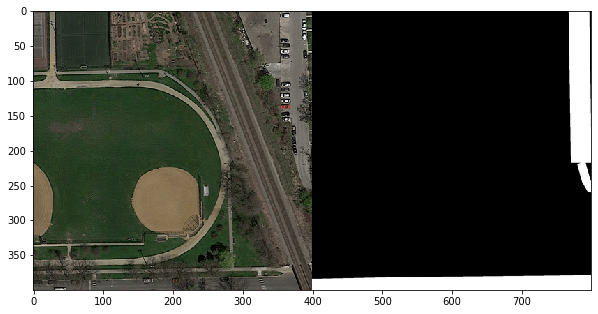

In [4]:
print_img_and_gt_img(imgs, gt_imgs, [0])

In [5]:
img_patches, gt_patches = extract_patches(imgs, gt_imgs, PATCH_SIZE)
print(img_patches.shape, gt_patches.shape)

(62500, 16, 16, 3) (62500, 16, 16)


In [6]:
X = standardize_color_features(img_patches)
y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
print(X.shape, y.shape)

(62500, 16, 16, 3) (62500,)


In [7]:
X, y = balance_data(X, y)

In [8]:
X_train, y_train, X_test, y_test = split_data(X, y, TRAINING_SET_SIZE, SEED)

In [9]:
X_train_node = tf.placeholder(tf.float32, shape=(None, PATCH_SIZE, PATCH_SIZE, NB_CHANNELS))
y_train_node = tf.placeholder(tf.float32, shape=(None, NB_LABELS))

In [10]:
#initialization of weight variable function
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1, seed=SEED)
    return tf.Variable(initial)

#initialization of bias variable function
def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

In [11]:
conv1_weights = weight_variable([5, 5, NB_CHANNELS, DEPTH])
conv1_biases = bias_variable([DEPTH])

conv2_weights = weight_variable([5, 5, DEPTH, 64])
conv2_biases = bias_variable([64])

fc1_weights = weight_variable([4*4*64, 512])
fc1_biases = bias_variable([512])

fc2_weights = weight_variable([512, NB_LABELS])
fc2_biases = bias_variable([NB_LABELS])

In [12]:
# 2D convolution, with 'SAME' padding (i.e. the output feature map has
# the same size as the input). Note that {strides} is a 4D array whose
# shape matches the data layout: [image index, y, x, depth].
conv1 = tf.nn.conv2d(X_train_node, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')

# Bias and rectified linear non-linearity.
relu = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))

# Max pooling. The kernel size spec {ksize} also follows the layout of
# the data. Here we have a pooling window of 2, and a stride of 2.
pool1 = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')

relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))

pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Reshape the feature map cuboid into a 2D matrix to feed it to the
# fully connected layers.
reshape = tf.reshape(pool2, [-1, 4*4*64])

# Fully connected layer. Note that the '+' operation automatically
# broadcasts the biases.
hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

# Add a dropout. Dropout also scales activations such that
# no rescaling is needed at evaluation time.
keep_prob = tf.placeholder('float')
hidden = tf.nn.dropout(hidden, keep_prob, seed=SEED)

# Get the output layer
logits = tf.matmul(hidden, fc2_weights) + fc2_biases
y_pred_train_node = tf.nn.softmax(logits)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_train_node, logits=logits))

In [14]:
# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) + tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))

In [15]:
# Add the regularization term to the loss.
loss += 0.01 * regularizers

In [ ]:
# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
        0.01,                # Base learning rate.
        batch * BATCH_SIZE,  # Current index into the dataset.
        train_size,          # Decay step.
        0.95,                # Decay rate.
        staircase=True)

In [16]:
# Use AdamOptimizer for the optimization.
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [17]:
predict = tf.argmax(y_pred_train_node, 1)
correct_prediction = tf.equal(predict, tf.argmax(y_train_node, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [18]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

In [19]:
epochs_completed = 0
index_in_epoch = 0
num_samples = X_train.shape[0]

def next_batch(batch_size, X_train, y_train, index_in_epoch, epochs_completed, seed):
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > num_samples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        np.random.seed(seed)
        perm = np.random.permutation(num_samples)
        X_train = X_train[perm]
        y_train = y_train[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
    end = index_in_epoch
    return X_train[start:end], y_train[start:end], epochs_completed, index_in_epoch

In [20]:
import sklearn.metrics

#define parameters for training
TRAINING_ITERATIONS = 10000        
DROPOUT = 0.5

training_accuracies = []
training_f1_scores = []
validation_accuracies = []
validation_f1_scores = []
display_step = 100

for i in range(TRAINING_ITERATIONS):
    batch_xs, batch_ys, epochs_completed, index_in_epoch = next_batch(BATCH_SIZE, X_train, y_train, index_in_epoch, epochs_completed, SEED)  
    
    if (i % display_step == 0):
        training_accuracy = accuracy.eval(feed_dict={X_train_node:batch_xs, y_train_node: batch_ys, keep_prob: 1.0})
        training_predictions = predict.eval(feed_dict={X_train_node:batch_xs, keep_prob: 1.0})
        f1_score_training = sklearn.metrics.f1_score(np.argmax(batch_ys, axis=1), training_predictions)
        training_f1_scores.append(f1_score_training)

        validation_predictions = predict.eval(feed_dict={X_train_node: X_test[0:BATCH_SIZE], keep_prob: 1.0})
        validation_accuracy = accuracy.eval(feed_dict={X_train_node: X_test[0:BATCH_SIZE], y_train_node: y_test[0:BATCH_SIZE], keep_prob: 1.0})
        f1_score_validation = sklearn.metrics.f1_score(np.argmax(y_test[0:BATCH_SIZE],axis=1), validation_predictions)
        validation_f1_scores.append(f1_score_validation)
        print('training_accuracy = %.2f // validation_accuracy = %.2f // STEP = %d'%(training_accuracy, validation_accuracy, i))
        print('training_f1_score = %.2f // validation_f1_score = %.2f // STEP = %d'%(f1_score_training, f1_score_validation, i))
        validation_accuracies.append(validation_accuracy)

    training_accuracies.append(training_accuracy)
            
    # train CNN
    sess.run(train_step, feed_dict={X_train_node: batch_xs, y_train_node: batch_ys, keep_prob: DROPOUT})

training_accuracy = 0.50 // validation_accuracy = 0.52 // STEP = 0
training_f1_score = 0.39 // validation_f1_score = 0.43 // STEP = 0
training_accuracy = 0.59 // validation_accuracy = 0.59 // STEP = 100
training_f1_score = 0.48 // validation_f1_score = 0.56 // STEP = 100
training_accuracy = 0.64 // validation_accuracy = 0.64 // STEP = 200
training_f1_score = 0.67 // validation_f1_score = 0.67 // STEP = 200
training_accuracy = 0.67 // validation_accuracy = 0.61 // STEP = 300
training_f1_score = 0.65 // validation_f1_score = 0.57 // STEP = 300
training_accuracy = 0.70 // validation_accuracy = 0.62 // STEP = 400
training_f1_score = 0.67 // validation_f1_score = 0.63 // STEP = 400
training_accuracy = 0.68 // validation_accuracy = 0.66 // STEP = 500
training_f1_score = 0.67 // validation_f1_score = 0.70 // STEP = 500
training_accuracy = 0.61 // validation_accuracy = 0.65 // STEP = 600
training_f1_score = 0.58 // validation_f1_score = 0.65 // STEP = 600
training_accuracy = 0.68 // validation